# Taller 2 Centro Colombia eficiente

## Imports

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

## Carga de Datos

In [2]:
def detect_header_row(xlsx_path: str, max_search: int = 30) -> int:
    raw = pd.read_excel(xlsx_path, header=None)
    for i in range(min(max_search, len(raw))):
        row = raw.iloc[i].astype(str).str.upper().tolist()
        if any('LATITUD' == x for x in row) and any('LONGITUD' == x for x in row):
            return i
    return 0

def load_points(xlsx_path: str) -> pd.DataFrame:
    hdr = detect_header_row(xlsx_path)
    df = pd.read_excel(xlsx_path, header=hdr)
    df.columns = [str(c).strip().upper() for c in df.columns]
    name_col_candidates = [c for c in df.columns if 'NOMBRE' in c or 'MUNICIPIO' in c or 'POBLADO' in c]
    lat_col_candidates = [c for c in df.columns if 'LAT' in c]
    lon_col_candidates = [c for c in df.columns if 'LON' in c]
    if not lat_col_candidates or not lon_col_candidates:
        raise ValueError("No se encontraron columnas de LAT/LON.")
    name_col = name_col_candidates[0] if name_col_candidates else None
    lat_col = lat_col_candidates[0]
    lon_col = lon_col_candidates[0]
    keep = [c for c in [name_col, lat_col, lon_col] if c is not None]
    clean = df[keep].dropna()
    rename_map = {}
    if name_col: rename_map[name_col] = 'name'
    rename_map[lat_col] = 'lat'
    rename_map[lon_col] = 'lon'
    clean = clean.rename(columns=rename_map).reset_index(drop=True)
    return clean[['lat','lon'] + (['name'] if 'name' in clean.columns else [])]


## Algortimo Welz

En esta seccion hay que tener cuidado con las rutas de salida de los resultados:

```python
def run_and_plot(xlsx_path: str, out_png: str = "../results/mec_colombia_visualizacion_innocent.png"):
```

In [3]:
def norm2(p, q):
    dx = p[0]-q[0]; dy = p[1]-q[1]
    return dx*dx + dy*dy

def circle_from_one_point(p):
    return (np.array([p[0], p[1]], dtype=float), 0.0)

def circle_from_two_points(p, q):
    center = (np.array(p, dtype=float) + np.array(q, dtype=float)) / 2.0
    r2 = norm2(center, p)
    return (center, math.sqrt(r2))

def circumcircle(p, q, r):
    (ax, ay), (bx, by), (cx, cy) = p, q, r
    d = 2 * (ax*(by - cy) + bx*(cy - ay) + cx*(ay - by))
    if abs(d) < 1e-18:
        return None
    ux = ((ax*ax + ay*ay)*(by - cy) + (bx*bx + by*by)*(cy - ay) + (cx*cx + cy*cy)*(ay - by)) / d
    uy = ((ax*ax + ay*ay)*(cx - bx) + (bx*bx + by*by)*(ax - cx) + (cx*cx + cy*cy)*(bx - ax)) / d
    center = np.array([ux, uy], dtype=float)
    r = math.sqrt(norm2(center, p))
    return (center, r)

def circle_from_three_points(p, q, r):
    cc = circumcircle(p, q, r)
    if cc is not None:
        return cc
    candidates = [circle_from_two_points(p, q),
                  circle_from_two_points(p, r),
                  circle_from_two_points(q, r)]
    def contains_all(circ):
        c, rad = circ
        return (math.sqrt(norm2(c, p)) <= rad + 1e-12 and
                math.sqrt(norm2(c, q)) <= rad + 1e-12 and
                math.sqrt(norm2(c, r)) <= rad + 1e-12)
    best = None
    for cand in candidates:
        if contains_all(cand):
            if best is None or cand[1] < best[1]:
                best = cand
    return best

def is_in_circle(point, center, radius, eps=1e-12):
    return math.sqrt(norm2(point, center)) <= radius + eps

def mec_welzl_iterative(points: np.ndarray, seed: int = 42, return_support: bool = False):

    P = points.astype(float).copy()
    rng = np.random.default_rng(seed)
    rng.shuffle(P)

    center = np.array([0.0, 0.0], dtype=float)
    radius = 0.0
    support = [] 
    def inside(pt):
        return is_in_circle(pt, center, radius, eps=1e-12)

    for i in range(len(P)):
        p = P[i]
        if inside(p):
            continue
        center = p.astype(float)
        radius = 0.0
        support = [p]
        for j in range(i):
            q = P[j]
            if is_in_circle(q, center, radius, eps=1e-12):
                continue
            c, r = circle_from_two_points(p, q)
            center, radius = c, r
            support = [p, q]
            for k in range(j):
                rpt = P[k]
                if is_in_circle(rpt, center, radius, eps=1e-12):
                    continue
                cc = circle_from_three_points(p, q, rpt)
                if cc is None:
                    cands = [circle_from_two_points(p, q),
                             circle_from_two_points(p, rpt),
                             circle_from_two_points(q, rpt)]
                    cc = min(cands, key=lambda cr: cr[1])
                center, radius = cc
                support = [p, q, rpt]

    if return_support:
        return (center, radius, np.array(support))
    else:
        return (center, radius)

def mec_welzl_recursive(points: np.ndarray, seed: int = 42, return_support: bool = False):
    P = [np.array(p, dtype=float) for p in points]
    random.Random(seed).shuffle(P)

    def trivial(R):
        if len(R) == 0:
            return (np.array([0.0, 0.0]), 0.0, [])
        elif len(R) == 1:
            c, r = circle_from_one_point(R[0]);   return (c, r, [R[0]])
        elif len(R) == 2:
            c, r = circle_from_two_points(R[0], R[1]);   return (c, r, [R[0], R[1]])
        else:
            c, r = circle_from_three_points(R[0], R[1], R[2])
            if c is None:
                cands = [circle_from_two_points(R[0], R[1]),
                         circle_from_two_points(R[0], R[2]),
                         circle_from_two_points(R[1], R[2])]
                c, r = min(cands, key=lambda t: t[1])
                R = [R[0], R[1]] 
            return (c, r, R[:3])

    def welzl(i, R):
        if i == 0 or len(R) == 3:
            return trivial(R)
        p = P[i-1]
        c, r, supp = welzl(i-1, R)
        if is_in_circle(p, c, r):
            return (c, r, supp)
        else:
            return welzl(i-1, R + [p])

    c, r, supp = welzl(len(P), [])
    if return_support:
        return (c, r, np.array(supp))
    else:
        return (c, r)


def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    phi1 = math.radians(lat1); phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1); dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


def run_and_plot(xlsx_path: str, out_png: str = "../results/mec_colombia_visualizacion_welzl_recursivo.png"):
    df = load_points(xlsx_path)
    pts = df[['lat','lon']].to_numpy()

    import sys
    sys.setrecursionlimit(max(2000, len(pts) + 100))

    try:
        center_deg, radius_deg, support = mec_welzl_recursive(pts, seed=123, return_support=True)
    except RecursionError:
        print('Pasando a Welzl iterativo')
        center_deg, radius_deg, support = mec_welzl_iterative(pts, seed=123, return_support=True)

    center_lat, center_lon = float(center_deg[0]), float(center_deg[1])

    dists_km = [haversine_km(center_lat, center_lon, float(p[0]), float(p[1])) for p in pts]
    radius_km = max(dists_km)

    fig, ax = plt.subplots(figsize=(8,10))
    ax.scatter(pts[:,1], pts[:,0], s=5, alpha=0.7, label="Poblaciones")
    theta = np.linspace(0, 2*np.pi, 720)
    circle_lat = center_lat + radius_deg * np.sin(theta)
    circle_lon = center_lon + radius_deg * np.cos(theta)
    ax.plot(circle_lon, circle_lat, linewidth=1.2, label="Circunferencia (MEC)")
    ax.scatter([center_lon], [center_lat], marker='x', s=60, label="Centro")
    if support is not None and len(support) > 0:
        ax.scatter(support[:,1], support[:,0], s=30, marker='o', facecolors='none', label="Soporte")

    ax.set_xlabel("Longitud (°)"); ax.set_ylabel("Latitud (°)")
    ax.set_title("Círculo mínimo (Welzl recursivo) — Poblaciones de Colombia")
    ax.legend(loc="best"); ax.set_aspect('equal', adjustable='box')
    fig.tight_layout(); fig.savefig(out_png, dpi=200)

    return (center_lat, center_lon, radius_deg, radius_km, out_png)


## Ejecucion

En este caso pasa lo mismo, si no se tiene el repositorio clonado, se recomienda cambiar las rutas de:

```python
center_lat, center_lon, rdeg, rkm, out = run_and_plot("../data/DIVIPOLA_Municipios.xlsx")
```

{'Centro:': (4.910525408, -75.7095111995), 'Radio (°):': 10.165067515456498, 'Radio (km):': 1129.9623280345188, 'PNG:': '../results/mec_colombia_visualizacion_welzl_recursivo.png'}


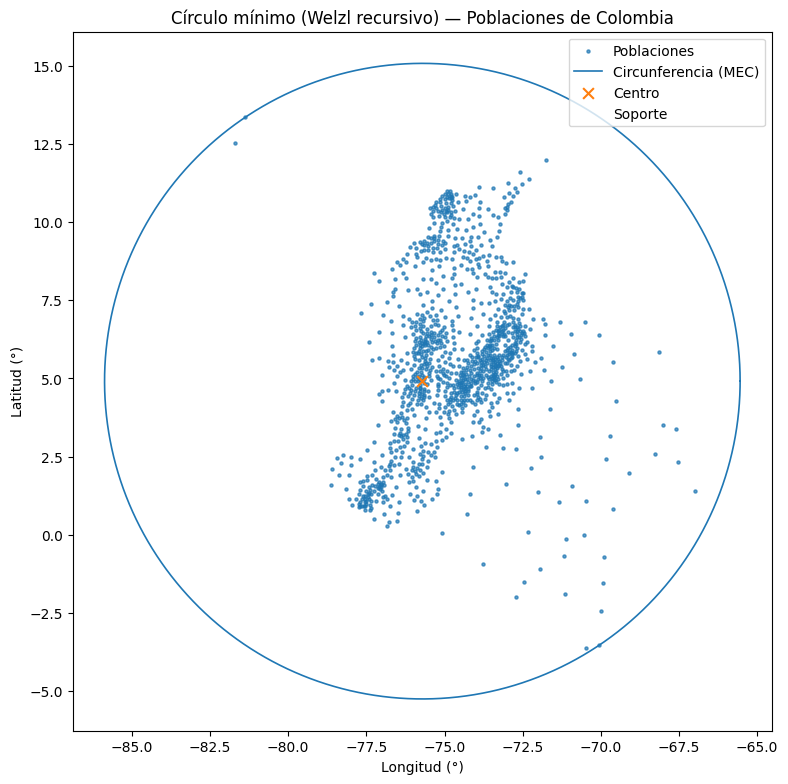

In [4]:
center_lat, center_lon, rdeg, rkm, out = run_and_plot("../data/DIVIPOLA_Municipios.xlsx")
data = {"Centro:": (center_lat, center_lon), "Radio (°):": rdeg, "Radio (km):": rkm, "PNG:": out}
print(data)
pd.DataFrame(data).to_csv('../results/data_welzl.csv')